# What are the chances for a claim to get approved?

In this notebook, I explore the <i>claims.csv</i> file and build a simple logistic regression model to predict the probability of a claim getting approved.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [2]:
# read in data
claims = pd.read_csv('../CoverMyMeds_data/dim_claims.csv')

## Explore claims data

In [3]:
claims.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved
0,1,417380,A,75.0,0
1,2,999001,A,NaN,1
2,3,417740,A,76.0,0
3,4,999001,A,NaN,1
4,5,417740,A,NaN,1


In [4]:
# Check dtypes of claims 
claims.dtypes

dim_claim_id                 int64
bin                          int64
drug                        object
reject_code                float64
pharmacy_claim_approved      int64
dtype: object

In [5]:
# replace nan with -99
claims['reject_code'].replace(np.nan, -99, inplace=True)

In [6]:
# Unique payers 
claims.bin.unique()

array([417380, 999001, 417740, 417614])

In [7]:
# Add new column payer
# convert bin from int to str
claims['payer'] = ''

In [8]:
# rename payers for brevity

claims.loc[claims.bin==417380, 'payer'] = 'C1'
claims.loc[claims.bin==999001, 'payer'] = 'C2'
claims.loc[claims.bin==417740, 'payer'] = 'C3'
claims.loc[claims.bin==417614, 'payer'] = 'C4'

In [9]:
claims.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,payer
0,1,417380,A,75.0,0,C1
1,2,999001,A,-99.0,1,C2
2,3,417740,A,76.0,0,C3
3,4,999001,A,-99.0,1,C2
4,5,417740,A,-99.0,1,C3


In [10]:
# Add new column reject_reason
claims['reject_reason'] = 'approved'

In [11]:
# convert reject_code from float to str for easy readability
claims.loc[claims.reject_code==70, 'reject_reason'] = 'Not_in_formulary'
claims.loc[claims.reject_code==75, 'reject_reason'] = 'In_formulary_needs_PA'
claims.loc[claims.reject_code==76, 'reject_reason'] = 'In_formulary_exceeded_limit'

In [12]:
# create new feature 
claims['drug_payer'] = claims['drug'].astype(str)+'_'+claims['payer'].astype(str)

In [13]:
claims.head()

,dim_claim_id,bin,drug,reject_code,pharmacy_claim_approved,payer,reject_reason,drug_payer
0,1,417380,A,75.0,0,C1,In_formulary_needs_PA,A_C1
1,2,999001,A,-99.0,1,C2,approved,A_C2
2,3,417740,A,76.0,0,C3,In_formulary_exceeded_limit,A_C3
3,4,999001,A,-99.0,1,C2,approved,A_C2
4,5,417740,A,-99.0,1,C3,approved,A_C3


In [14]:
# Keep columns
keep_columns = ['drug','payer']


# X and y
X = claims[keep_columns]
y = claims['pharmacy_claim_approved']

In [15]:
# Number of approved claims
len(y[y==1])

779625

In [16]:
# Number of rejected claims
len(y[y==0])

555951

In [17]:
# Since X columns are categorical, create dummy variables through one-hot encoding
X_oneHotEncode = pd.get_dummies(X, drop_first=True)

In [18]:
X_oneHotEncode.head()

,drug_B,drug_C,payer_C2,payer_C3,payer_C4
0,0,0,0,0,0
1,0,0,1,0,0
2,0,0,0,1,0
3,0,0,1,0,0
4,0,0,0,1,0


In [19]:
# train_test_split
from sklearn.model_selection import train_test_split

In [20]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_oneHotEncode, y, test_size=0.25, random_state=42, stratify = y)

In [21]:
# length of X_train
len(X_train)

1001682

In [22]:
# length of X_test
len(X_test)

333894

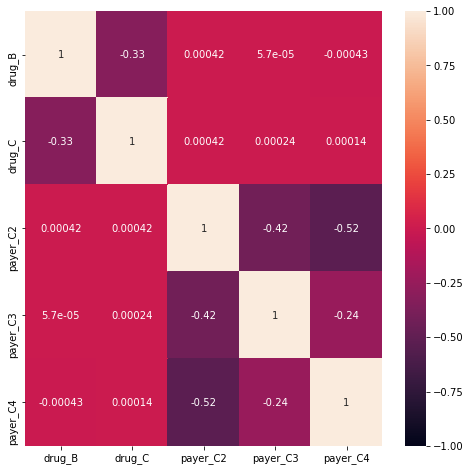

In [23]:
# correlation between independent features
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(X_train.corr(), vmin=-1, vmax=1, annot=True)

#### There is some anticorrelation between the features payer_C2, payer_C3 and payer_C2, payer_C4. Given, that its not very strong, it is ignored for the time being.

# Logistic Regression

In [24]:
# Import packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [25]:
# Since the y=1 class is dominating over the y=0 class, I use class weights to balance the classes.

# calculate class weights
# Wj = n_samples / (n_classes * n_samples_j)

W_0 = len(y)/(2*len(y[y==0]))
W_1 = len(y)/(2*len(y[y==1]))

print(W_0)
print (W_1)

1.2011634118834214
0.8565502645502645


In [26]:
# Logistic regression object
clf = LogisticRegression(random_state = 42, solver= 'lbfgs', class_weight={0:W_0, 1:W_1})

In [27]:
# cross-validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# evaluate model
scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

# report performance
print('ROC_AUC: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

ROC_AUC: 0.852 (0.001)


In [28]:
# fit model
clf.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1.2011634118834214, 1: 0.8565502645502645},
                   random_state=42)

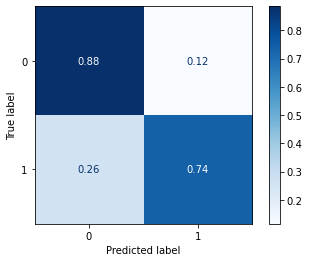

In [29]:
# confusion matrix
plot_confusion_matrix(clf, X_train, y_train,cmap=plt.cm.Blues, normalize='true')
plt.savefig('../Plots/Claims_ConfusionMatrix.png')
plt.show()  

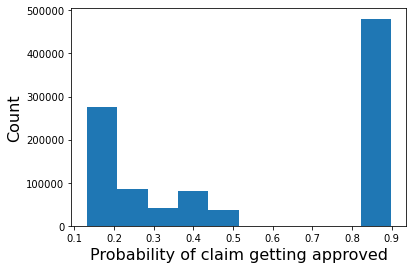

In [31]:
# probability distribution of predictions

proba = clf.predict_proba(X_train)[:,1]
plt.hist(proba)
plt.xlabel('Probability of claim getting approved', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.savefig('../Plots/Claims_probabilityDistribution.png')
plt.show()

<AxesSubplot:>

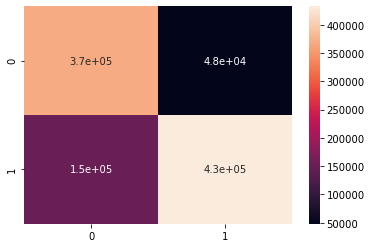

In [32]:
thresh = 0.5
y_test_pred = np.where(proba>thresh, 1, 0)
cm = confusion_matrix(y_train,y_test_pred)
sns.heatmap(cm, annot=True)

In [33]:
# A simple function to predict the probability of claim approval given drug and payer information

def WillClaimGetApproved(Drug, Payer):
    
    # Input array
    X = np.array(['B','C','999001','417740','417614'])
    
    # Convert input array to boolean based on drug and payer 
    X1 = np.where((X==Drug)|(X==Payer), 1, 0)
    
    # predict probability
    pred_prob = clf.predict_proba(X1.reshape(1,-1))
    
    # probability threshold
    thresh = 0.5
    
    if pred_prob[0][1] < 0.5 :
        
        # reject_reason 
        reject_reason = claims[(claims['drug']==Drug) & (claims['bin']==int(Payer)) & (claims['pharmacy_claim_approved']==0)]['reject_reason']
        
        print (f'Your claim has {round((1-pred_prob[0][1]),2)*100} % chance to be rejected. You will need a PA. Reason for rejection : {np.array(reject_reason)[0]}')
    
    else:
        print (f'Your claim has {round(pred_prob[0][1],2)*100} % chance of approval. You don\'t need a PA.')
    
    return None
        
    
    
    

In [34]:
# What the app should do
WillClaimGetApproved('A','417614')

Your claim has 84.0 % chance to be rejected. You will need a PA. Reason for rejection : Not_in_formulary


### Interpreting coefficients of logisitc regression

In [30]:
# coefficients of logistic regressor (log odds)
clf.coef_

array([[-0.23476799,  0.31980895,  3.43715472,  1.05077146, -0.07790327]])

In [43]:
# Odds ratio (OR)
OR = np.exp(clf.coef_)

In [45]:
OR

array([[ 0.79075429,  1.37686469, 31.09834868,  2.85985653,  0.9250539 ]])

### Odds ratio

#### The odds of claim approval for drug B and drug C are 0.79 and 1.38 times that  of drug A respectively, keeping all other values constant.
#### The odds of claim approval for payer_C2, payer_C3 and payer_C4 are 31.1, 2.86 and 0.93 times that of payer_C1 respectively, keeping all other values constant.

#### Note : The minor correlation between the drugs and payers may influence the coefficients. 

# statsmodel 
#### Check the significance of the model

In [35]:
# import statsmodel
import statsmodels.api as sm

In [36]:
# Fit model
model = sm.Logit(endog=y_train, exog=sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.452088
         Iterations 6


In [37]:
# Model summary
print(model.summary())

                              Logit Regression Results                             
Dep. Variable:     pharmacy_claim_approved   No. Observations:              1001682
Model:                               Logit   Df Residuals:                  1001676
Method:                                MLE   Df Model:                            5
Date:                     Tue, 25 May 2021   Pseudo R-squ.:                  0.3342
Time:                             10:59:38   Log-Likelihood:            -4.5285e+05
converged:                            True   LL-Null:                   -6.8020e+05
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2670      0.007   -177.877      0.000      -1.281      -1.253
drug_B        -0.1880      0.006    -29.323      0.000      -0.201      -0.175
drug_C      

#### All the features have p-value < 0.05 and a z-value far from 0.  The 95% confidence interval for all features exclude 0, meaning the features are significant. 

# Save model

In [39]:
from joblib import dump, load
dump(clf, '../Models/ClaimsModel_logistic.joblib') 

['../Models/ClaimsModel_logistic.joblib']